**Getting Started with IntelligentGraph**

To enable the IntelligentGraph capabilities within a IJava notebook import the JAR, normally named and identified as follows:

In [1]:
%jars /usr/share/intelligentgraph-0.1.0.jar

You will also need to 'import' the classes that you will use in your code:

In [2]:
import pathCalc.Thing;
import pathQLModel.Resource;
import pathCalc.Evaluator;
import pathQLRepository.*;

You need to access an existing IntelligentGraph repository, and in this example assign it to the variable 'source'

In [3]:
PathQLRepository source = PathQLRepository.create("http://host.docker.internal:8080/rdf4j-server","calc2graph");

Carefully note the use of 'http://host.docker.internal:8080'. This is the equivalent of 'http://localhost:8080' when Jupyter is running in a Docker container accessing a Repository on 'http://localhost:8080'

Unless you like typing in the full IRI  (aka URL) of 'things, it is a good idea to define some prefixes so we can use qNames instead:

In [4]:
source.prefix("<http://inova8.com/calc2graph/def/>");
source.prefix("rdfs","<http://www.w3.org/2000/01/rdf-schema#>");

pathQLRepository.PathQLRepository@516056b1

Just to make sure we are stating with a clean sheet, lets remove the graph:

In [5]:
source.removeGraph("<http://inova8.com/calc2graph/testGraph2>");

Next we want to add our own graph. Think of the PathQLRepository as a huge spreadsheet workbook, and a Graph is a new worksheet. <p/>
We give this graph a name, which is of course a IRI (everything in the Graph-world is identified by a IRI. Linger too long near a graph and you will become an IRI in it as well:-)

In [6]:
Graph graph = source.addGraph("<http://inova8.com/calc2graph/testGraph2>");

If you have access to the repository sever you will see that a new 'context' (aka graph) has been added as shown:<p/>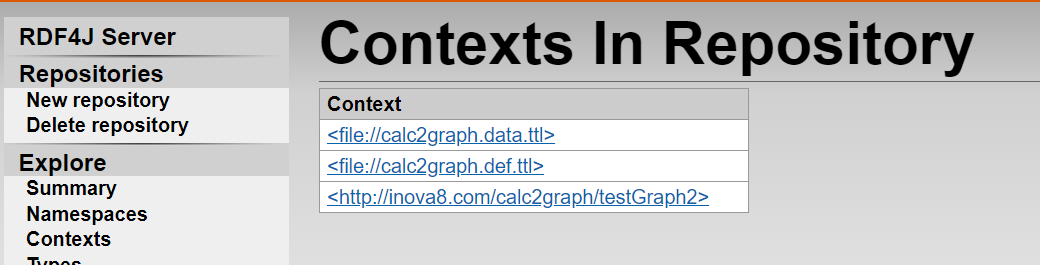

We are now ready to create 'things' in this graph. Think of a new thing as a new row in a spreadsheet workbook:

In [7]:
Thing myCountry = graph.getThing(":Country1");

So now lets add some facts to this 'myCountry' thing. Think of this as adding values to cells within the row of the workbook. The name of the fact (in this case :sales, which is shorthand for <http://inova8.com/calc2graph/def/sales>) can be thought of as a column in workbook. However since we are adding multiple values, the spreadsheet metaphor breaks down a bit: we are adding multiple distinct values to the cell, something with which most spreadsheets would struggle.

In [8]:
myCountry.addFact(":sales", "1");
myCountry.addFact(":sales", "2");
myCountry.addFact(":sales", "3");
myCountry.addFact(":sales", "4");
myCountry.addFact(":sales", "5");

http://inova8.com/calc2graph/def/Country1

We could revert to the repository server to view the contents of oyur newly created graph:<p/>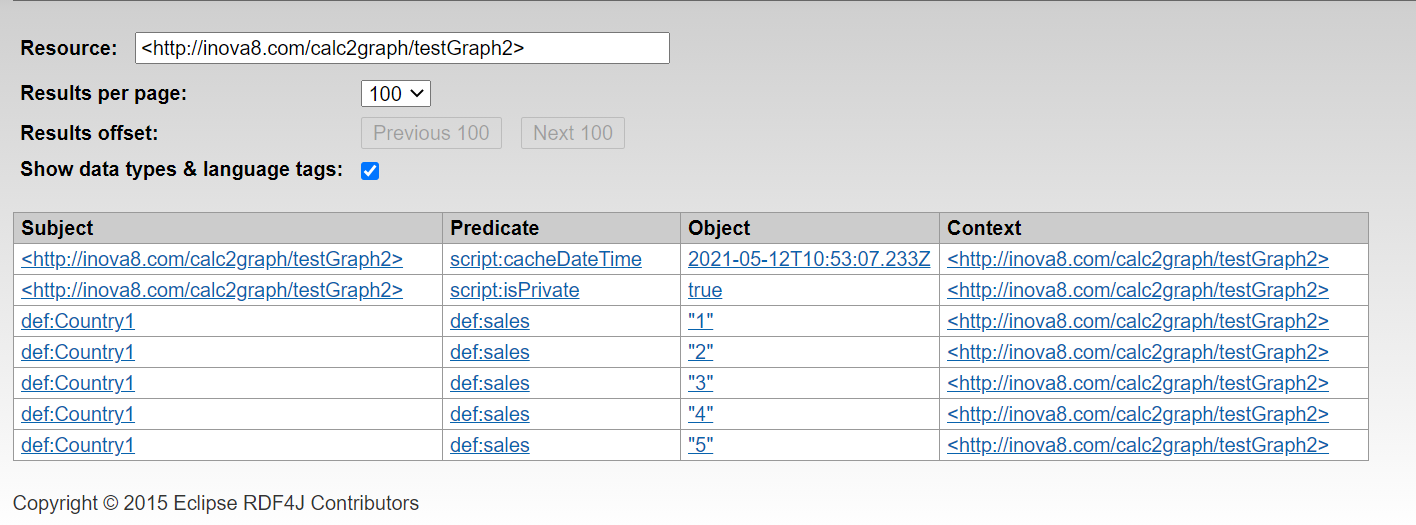

But that defeats the objective of using a Jupyter LabNotebook! Let's instead iterate over the contents

In [9]:
for (Resource sale : myCountry.getFacts(":sales")){
   System.out.println(sale.doubleValue() ); 
}

1.0
2.0
3.0
4.0
5.0


Note that on execution you might get a report stating which calculation scripting engines have bveen installed. More about that later.<p/>
Ok so we could perform some calculations on this, such as find the total sales in this country. The myCountry.getFacts(":sales") provides access to related facts. In this example, the argument ":sales" means get these facts. However this can be a pathQL expression, allowing access to any directly or indirectly related information.


In [10]:
double totalSales=0;
for (Resource sale : myCountry.getFacts(":sales")){
   totalSales+=sale.doubleValue() ;
}
System.out.println(totalSales ); 

15.0


So far not much more than the ubiquitous "Hello World". <p/>
Also everytime we want to see the sales of a country we would have to run this Notbook. Instead lets add a new 'fact' to the country which is the total sales value. 
However, instead of writing the value "15.0", as would be the usual approach for a datamart/datalake (via complicated ETL), let's embed the formula as the 'value' of the totalSales fact associated with the country.
This is equivalent to adding a macro to a cell in a spreadsheet referencing other cells.<p/>
The string averageSalesScript contains the macro, written in this example using Groovy<p/>
We then add this as the ":averageSales" fact to "myCountry", declaring it to be a Groovy script


In [11]:
String averageSalesScript = "totalSales=0; count=0;for(sales in $this.getFacts(\"<http://inova8.com/calc2graph/def/sales>\")){totalSales +=  sales.doubleValue();count++}; return totalSales/count;";
myCountry.addFact(":averageSales", averageSalesScript, Evaluator.GROOVY) ;

http://inova8.com/calc2graph/def/Country1

Now I can just ask for that 'fact' whenever I want, as if it were stored data in the graph.

In [12]:
myCountry.getFact(":averageSales")

"3.0"^^<http://www.w3.org/2001/XMLSchema#double>

What has actually been stored in the graph is the script, and IntelligentGraph will evaluate that scruipt on retrieval:<p/>
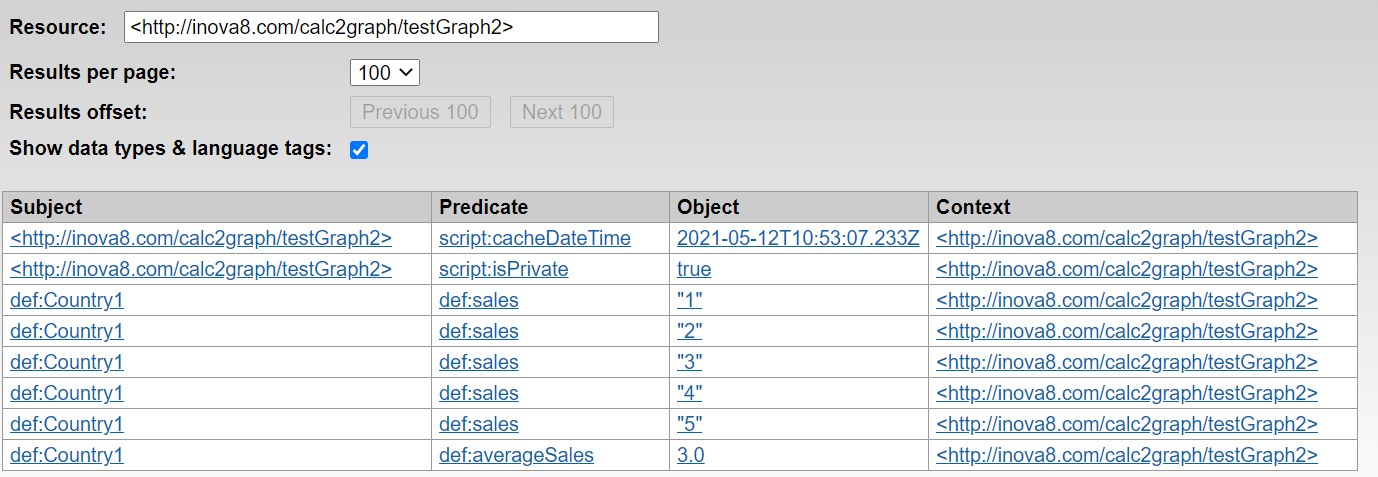


Sceptical? Add another sale, and ask for the average again.

In [13]:
myCountry.addFact(":sales", "500");
myCountry.getFact(":averageSales")

"3.0"^^<http://www.w3.org/2001/XMLSchema#double>

**IntelligentGraph FAQ**

*What about graph privacy?*<p/>
Everytime you create a graph for your persoanl use, only you can see it from within any Notebook. However, if you change it to a public graph, everyone will see your data and metrics.

*What about graph cleanup?*<p/>
You can cleanup after yourslef if you wish with source.removeGraph("<graphIRI>");

*What script languages can I use?*<p/>
It depends on what has been installed, but usually Java, Groovy, Javascript, and Python can be used.

*What about performance?*<p/>
The results of each script evaluation are cached, and these cached values will be used whenever possible. This, together with the fact that you do not have to ETL your data from the database, load it into some analysis tool, perform the calculation, add a new table to your database to host this new metric, then import your results back into the database (if you remember)! Now ask that question again:-)

*How to I access related data?*<p/>
The PathQL language allows one to directly or indirectly access related facts. Full details of PathQL's capabilities are contained here: [PathQL](http://inova8.com/bg_inova8.com/pathpatternql-intelligently-finding-knowledge-as-a-path-through-a-maze-of-facts/)

*Can I only access results via LabNotebooks?*<p/>
No. LabNotebooks is just a way of manipulating the graph, adding and testing calculations, and creating dynamic dashboards. All of the storage and heavy lifting is being done by the repository server. This Repository server can be accessed in eactly the same way as any [RDF4J](https://rdf4j.org/) repository server: [SPARQL](https://github.com/paulovn/sparql-kernel), [RDF4J API](https://rdf4j.org/documentation/programming/model/), [OData2SPARQL](http://inova8.com/bg_inova8.com/offerings/odata2sparql/), [Lens2OData](http://inova8.com/bg_inova8.com/offerings/lens2odata/) and more.

*Can scripts access parameters, such as date/time?*

Yes.<p/>Firstly scripts can access anything that is already in the graph using [PathQL](http://inova8.com/bg_inova8.com/pathpatternql-intelligently-finding-knowledge-as-a-path-through-a-maze-of-facts/) to access that data.<p/>Secondly all calculations have access to a calculation context. Think of this as shared memory. As an IntelligentGraph user you can add variables to this context, and then any running script can access the variable and its value.<p/>
However the scripts are in the Repository, so what happens in SPARQL you might ask. Well in this case the script will have access to any bind variable value within the SPARQL. In this example, the script would have access to the ?time value:<p/>
<code>SELECT * {VALUES(?time){("12:23pm")("12:45pm")) :Country1 :averageSales ?averageSales }</code>